In [35]:
import warnings
warnings.filterwarnings('ignore')


# 0. Data Science 101



An journey through data wrangling, visualization and modeling with some real world data.


## All too common question: Where do I start?


##Should I get a graduate degree in Statistics or Machine Learning?

#NO


## The world's data science problems will never be solved by this approach

##You are what you repeatedly do/practice.

##Mindset is more important than any particular technique


## Most important tools: 

##Curiosity, Patience, Common Sense, Healthy Skepticism


## Let's go on a first pass through a dataset, with a focus on exploration.


In [36]:
%pylab inline
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


#1. Meet the data
- 2015 NFL Regular Season Fanduel data
- Dataset contains a row for each player in the league, for each week
- Several Categorical variables (full_name, team, week, home_team, away_team)
- Several Numeric lag variables (mean_passing_att across all prior weeks, prev_passing_att for one prior week)

# Load dataset

In [63]:
raw_df = pd.read_csv("/home/brianb/Downloads/odsc_football_modeling_data_2.csv")
df_no_week_1 = raw_df[raw_df.week > 1]

#What columns do we have?


In [64]:
sort(raw_df.columns.values)

array(['away_team', 'fanduel_points', 'full_name', 'home_team',
       'mean_fanduel_points', 'mean_fumbles_lost', 'mean_fumbles_tot',
       'mean_passing_att', 'mean_passing_cmp', 'mean_passing_cmp_air_yds',
       'mean_passing_incmp', 'mean_passing_incmp_air_yds',
       'mean_passing_int', 'mean_passing_sk', 'mean_passing_sk_yds',
       'mean_passing_tds', 'mean_passing_yds', 'mean_receiving_rec',
       'mean_receiving_tar', 'mean_receiving_tds',
       'mean_receiving_yac_yds', 'mean_receiving_yds', 'mean_rushing_att',
       'mean_rushing_loss', 'mean_rushing_loss_yds', 'mean_rushing_tds',
       'mean_rushing_yds', 'opponent', 'player_id', 'position',
       'prev_fanduel_points', 'prev_fumbles_lost', 'prev_fumbles_tot',
       'prev_passing_att', 'prev_passing_cmp', 'prev_passing_cmp_air_yds',
       'prev_passing_incmp', 'prev_passing_incmp_air_yds',
       'prev_passing_int', 'prev_passing_sk', 'prev_passing_sk_yds',
       'prev_passing_tds', 'prev_passing_yds', 'prev_rec

#What is the distribution of points earned?

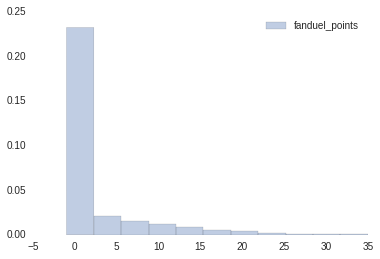

In [65]:
pylab.hist(raw_df['fanduel_points'],
               normed=True,
               bins=np.linspace(-1, 35, 12),
               alpha=0.35,
               label='fanduel_points')
pylab.legend()
pylab.figure(figsize=(15,15))

# Target is skewed --- let's transform it so it's more normal


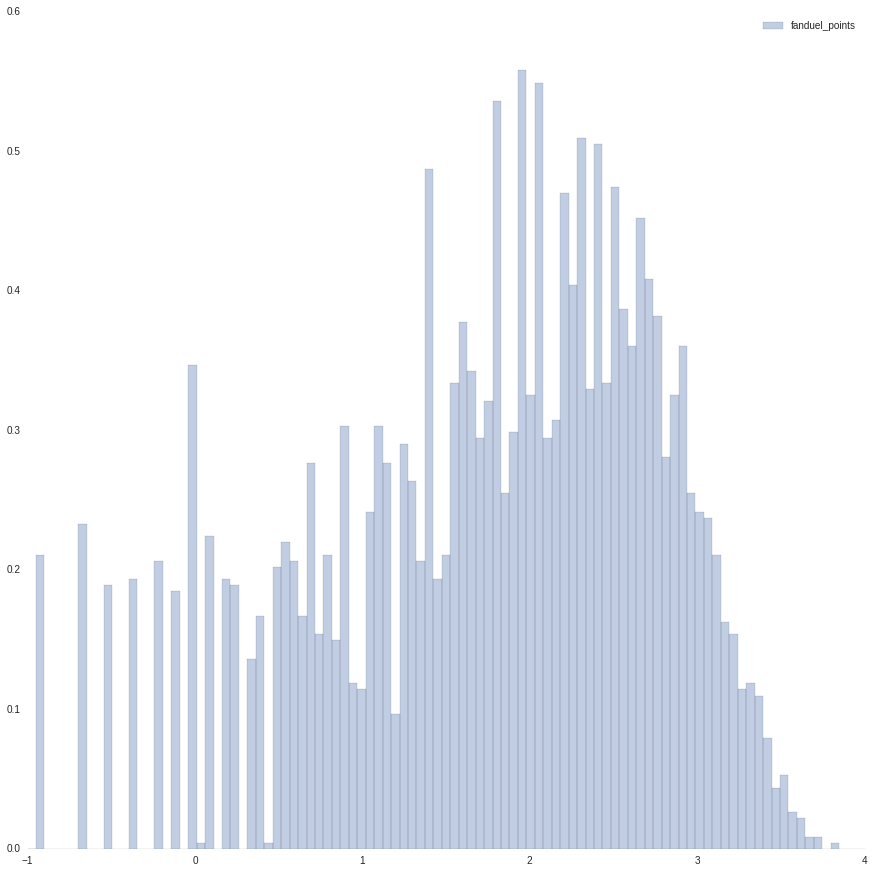

In [195]:
transformed_target = pd.DataFrame.copy(raw_df[raw_df.fanduel_points > 1])
transformed_target['fanduel_points'] = np.log(raw_df[raw_df.fanduel_points > 0]['fanduel_points']-1)
pylab.figure(figsize=(15,15))
pylab.hist(transformed_target['fanduel_points'],
               normed=True,
               bins=np.linspace(-1, 4, 100),
               alpha=0.35,
               label='fanduel_points')
pylab.legend()

# I see lots of zeroes --- Where are these bad performances coming from?



   position  count
24       WR   1822
3        DE   1276
19       RB   1226
1        CB   1161
15      OLB   1139
23       TE    948
2        DB    754
4        DT    724
10       LB    625
21       SS    532
18       QB    509
6        FS    500
9         K    462
17        P    443
8       ILB    414
22        T    332
13       NT    229
12      MLB    210
5        FB    175
7         G    147
0         C    142
14       OG    107
16       OT     94
11       LS     73
20      SAF      1


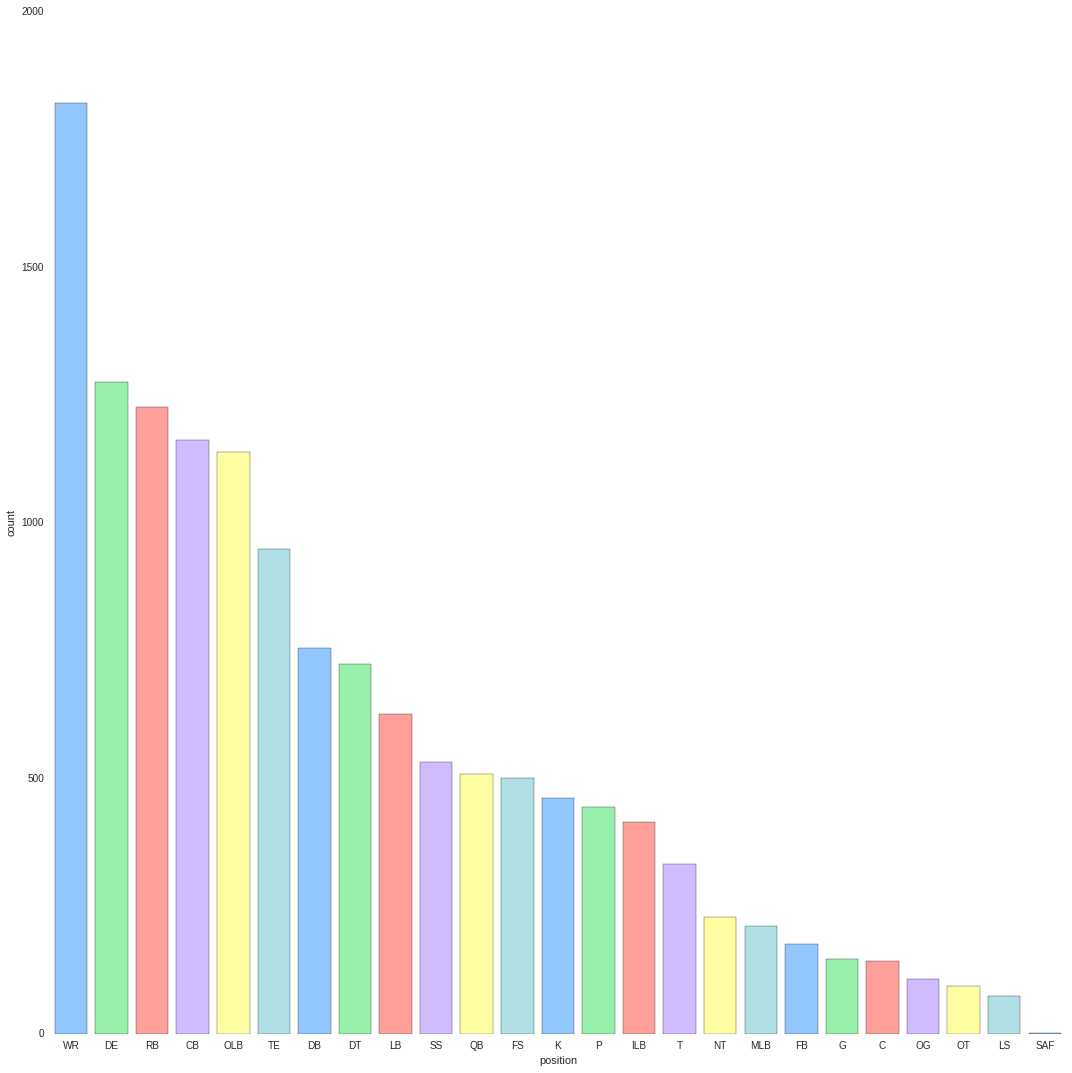

In [68]:
no_nans = raw_df[raw_df[raw_df.fanduel_points< 3].notnull()]

no_nans = raw_df[raw_df.position != 'UNK'] #remove Unknowns from this dataframe

no_nans.groupby('position').size()

bad_performances = pd.DataFrame({'count' : no_nans.groupby('position').size()}).reset_index()

bad_performances = bad_performances.sort(['count'], ascending=[0])

print bad_performances

g = sns.factorplot("position", "count",
                    data=bad_performances, kind="bar",
                    size=15, palette="pastel", dropna=True, x_order=bad_performances.position.values)


In [69]:
#Let's look at an individual player
raw_df[(raw_df.full_name =='Tom Brady') & (raw_df.week == 2)]

,player_id,full_name,position,team,week,fanduel_points,opponent,home_team,away_team,prev_fanduel_points,...,prev_rushing_att,mean_rushing_att,prev_rushing_loss,mean_rushing_loss,prev_rushing_loss_yds,mean_rushing_loss_yds,prev_rushing_tds,mean_rushing_tds,prev_rushing_yds,mean_rushing_yds
1149,00-0019596,Tom Brady,QB,NE,2,28.24,BUF,BUF,NE,27.62,...,3,3,0,0,0,0,0,0,1,1


In [70]:
#All positions are not created equal -- some score many more points than others
raw_df[raw_df[raw_df.fanduel_points> 1].notnull()].groupby('position')['fanduel_points'].sum()

position
CB         6.00
DB         9.00
FB       363.10
G          1.50
K       3506.12
NT         6.10
OT         3.60
P          5.80
QB      7861.24
RB      8849.84
T          1.20
TE      4656.70
UNK     5782.82
WR     12457.80
Name: fanduel_points, dtype: float64

In [71]:
#Since a few positions seem to score all the points, let's zoom in on those
plot_order = ['TE', 'WR', 'RB', 
              'K', 'QB']
top_positions_only = raw_df[raw_df.position.isin(plot_order)]
top_positions_only.groupby('position')['fanduel_points'].mean()

position
K      7.623636
QB    15.448330
RB     7.244731
TE     4.967405
WR     6.854775
Name: fanduel_points, dtype: float64

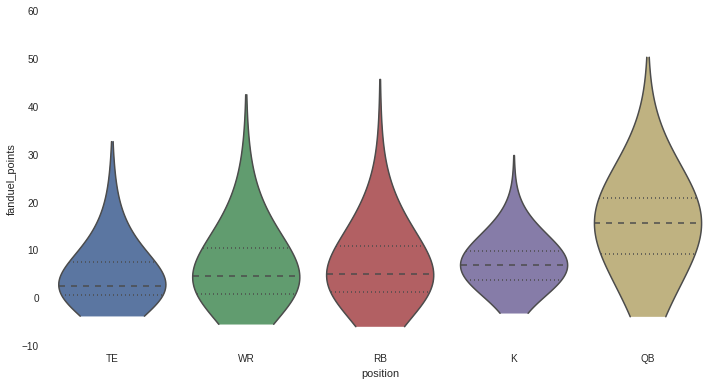

In [125]:
# Violin plots are a nice alternative to boxplots that also show interesting detail about
# the shape of the distribution
nonnull_subset = top_positions_only['fanduel_points'].notnull()
plt.figure(figsize=(12, 6))
sns.violinplot(top_positions_only['fanduel_points'][nonnull_subset], 
               top_positions_only['position'][nonnull_subset], 
               inner='box',
               order=plot_order,
               bw=1,
               size=16)

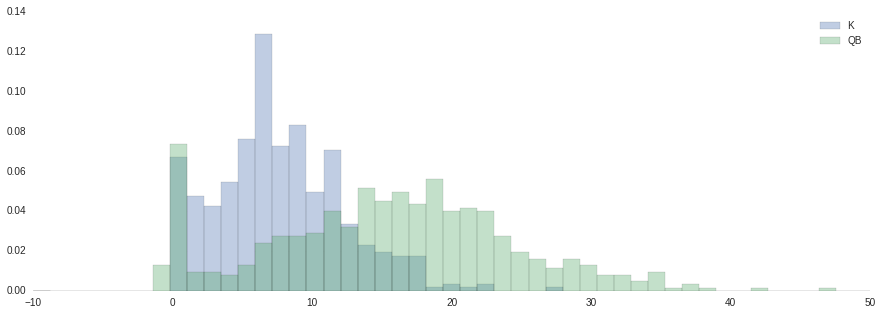

In [74]:
# QB's and kickers score the most points. Let's look into those using a Histogram
qb_k = ['K', 'QB']
qb_k_data = raw_df[raw_df.position.isin(qb_k)]
groups = qb_k_data.groupby('position').groups

pylab.figure(figsize=(15,5))
for key, row_ids in groups.iteritems():
    pylab.hist(qb_k_data['fanduel_points'][row_ids].values,
               normed=True,
               bins=np.linspace(-10, 50, 50),
               alpha=0.35,
               label=str(key))
pylab.legend()

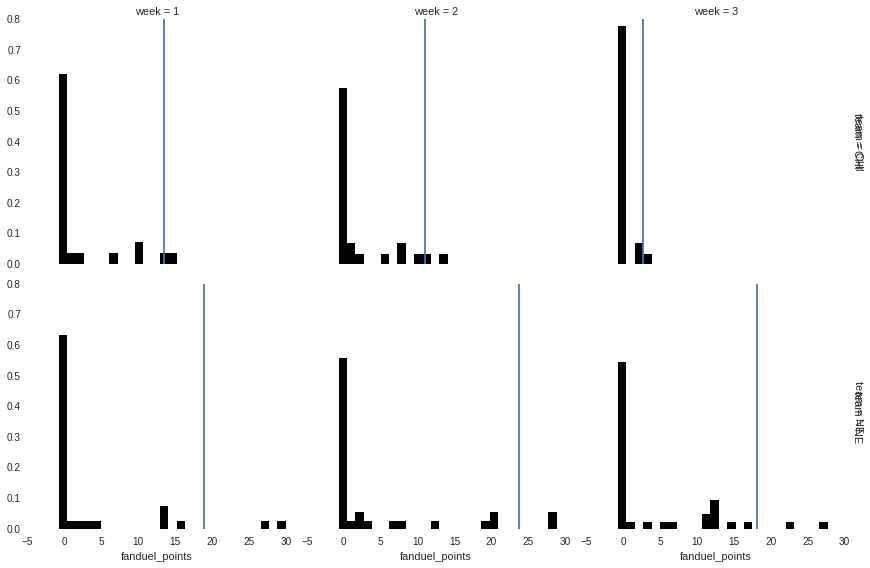

In [99]:
# We can use a Facetgrid to analyze teams

def vertical_mean_line(x, **kwargs):
    plt.axvline(np.percentile(x, 95), **kwargs)
    
teams = ['NE', 'CHI']
team_data = raw_df[raw_df.team.isin(teams)]
team_data = team_data[team_data.week < 4]

g = sns.FacetGrid(team_data, row="team", col="week", 
                  margin_titles=True, dropna=True, size=4)
bins = np.linspace(-3, 30, 30)
g.map(plt.hist, "fanduel_points", color="black", bins=bins, 
      lw=0, normed=True)
g.map(vertical_mean_line, 'fanduel_points')


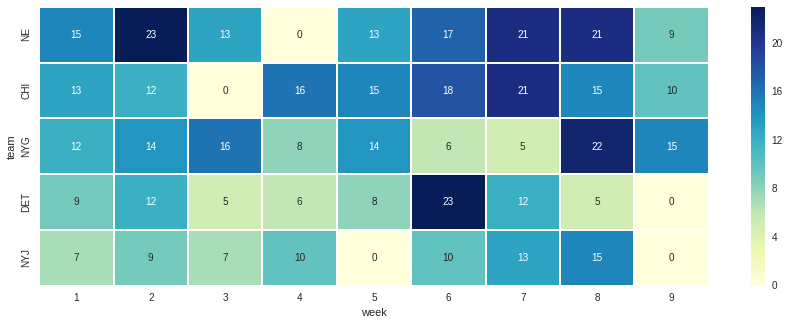

In [126]:
# We can use a Heatmap to analyze teams kicker and qb performance
teams = ['NE', 'CHI', 'NYG', 'DET', 'NYJ']
team_data = qb_k_data[qb_k_data.team.isin(teams)]
team_data = team_data[team_data.week < 10]
ptable = pd.pivot_table(
    team_data, 
    values='fanduel_points', 
    index=["team"], 
    columns='week')
reorder_teams = ptable.reindex(teams).fillna(0)
pylab.figure(figsize=(15,5))
sns.heatmap(reorder_teams.astype(int), annot=True, fmt="d", cmap="YlGnBu")

# Zero values are bye weeks



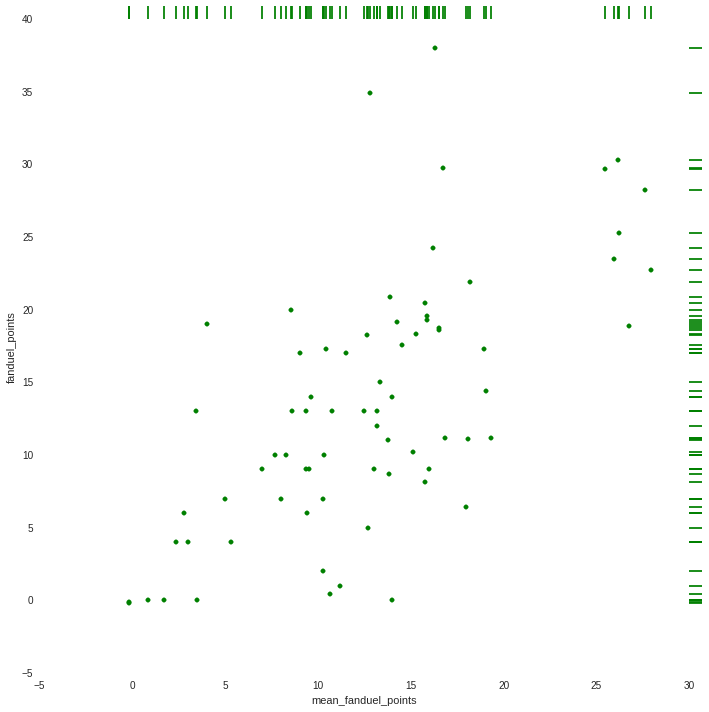

In [127]:
# Are previous week's points a good predictor of current week's points? 
# Let's consider only kicker and QB data for these teams
# We have to exclude week 1 here since there is no previous weeks' mean
team_data_no_week_1 = team_data[team_data.week > 1]
grid = sns.JointGrid(team_data_no_week_1['mean_fanduel_points'], 
              team_data_no_week_1['fanduel_points'],space=0, size=10, ratio=50)
grid.plot_joint(plt.scatter, color="g")
grid.plot_marginals(sns.rugplot, height=1, color="g")

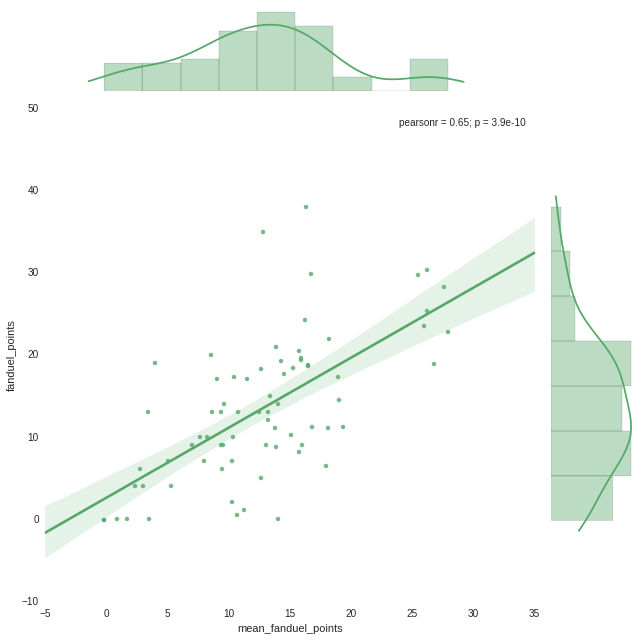

In [128]:
# We can use jointplot (uses JointGrid internally) to get a quick regression line for this
sns.jointplot('mean_fanduel_points', 'fanduel_points', data=team_data_no_week_1, 
              kind="reg", color=sns.color_palette()[1], size=9)

In [129]:
# QB's are significantly more important than any other position. Let's dig in
qb_df = raw_df[raw_df.position == 'QB']

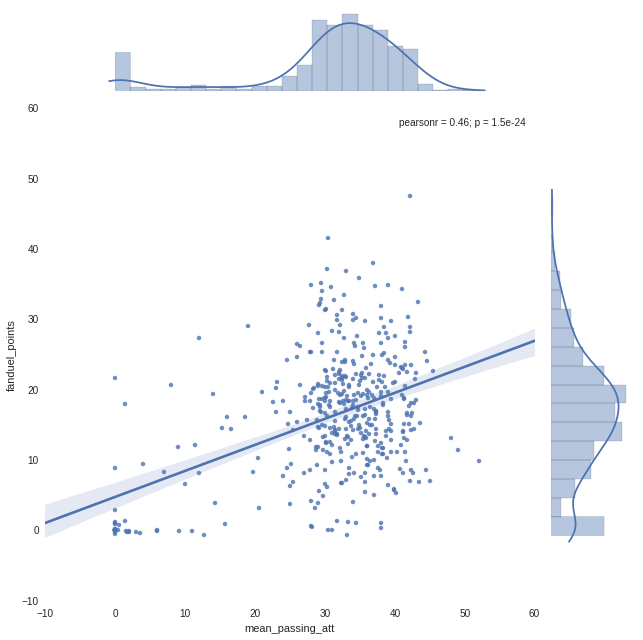

In [130]:
# Passing attempts from previous weeks --- is there a trend with next week's performance? No
sns.jointplot(qb_df['mean_passing_att'], 
              qb_df['fanduel_points'], kind="reg", size=9)

In [131]:
import sklearn


In [229]:
# Let's prep for modeling
exclude_week_1 = top_positions_only[top_positions_only.week > 1]

model_data = pd.DataFrame.copy(exclude_week_1)

model_data = model_data[model_data.fanduel_points > 0]

#model_data['fanduel_points'] = np.log(exclude_week_1['fanduel_points']-1)

print np.isnan(model_data['fanduel_points']).sum()

# Let's cut our target out so we don't train on it
target = model_data.pop('fanduel_points')

# We don't need player id's --- let's throw this away
throw_away = model_data.pop('player_id')

import sklearn.cross_validation

(train_data, 
 test_data, 
 train_target, 
 test_target) = sklearn.cross_validation.train_test_split(
    model_data, target, test_size=0.2, random_state=1337
)

0


In [230]:
#Handle categorical vars
import sklearn.preprocessing
import sklearn.feature_extraction
from sklearn.feature_extraction import DictVectorizer
encoder = DictVectorizer(sparse=False)

#Let's do one-hot encoding in sklearn using DictVectorizer
categorical_vars = ['full_name', 'position', 'team', 'week', 'opponent', 'home_team', 'away_team']
vardata = train_data[categorical_vars].fillna('MISSING')
encoder.fit(vardata.to_dict(orient='records'))
train_catdata = encoder.transform(vardata.to_dict(orient='records'))

test_vardata = test_data[categorical_vars].fillna('MISSING')
test_catdata = encoder.transform(
    test_vardata[categorical_vars].to_dict(orient='records'))

pd.DataFrame(train_catdata).describe()


,0,1,2,3,4,5,6,7,8,9,...,560,561,562,563,564,565,566,567,568,569
count,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,...,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000
mean,0.034810,0.028797,0.032278,0.033861,0.028165,0.035443,0.029747,0.029430,0.037975,0.030696,...,0.037658,0.039241,0.029114,0.033544,0.031962,0.029747,0.028797,0.044304,0.037975,9.587658
std,0.183328,0.167263,0.176767,0.180899,0.165469,0.184926,0.169915,0.169036,0.191165,0.172521,...,0.190398,0.194197,0.168152,0.180081,0.175927,0.169915,0.167263,0.205802,0.191165,4.691149
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,17.000000


In [231]:
#Handle numeric vars
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='median')

numeric_vars = list(set(train_data.columns.tolist()) - set(categorical_vars))

numdata = train_data[numeric_vars]
imputer.fit(numdata)

train_numdata = imputer.transform(numdata)
test_numdata = imputer.transform(test_data[numeric_vars])


In [232]:
train_this = np.hstack([train_numdata, train_catdata])
test_this = np.hstack([test_numdata, test_catdata])

In [233]:
import sklearn
from sklearn.linear_model import LinearRegression

print np.any(isnan(train_numdata))
print np.all(np.isfinite(train_numdata))

lr = LinearRegression(fit_intercept=False)
lr.fit(train_numdata, train_target)

lr_predictions = pd.Series(lr.predict(test_numdata),
                           name='Linear Regression')

False
True


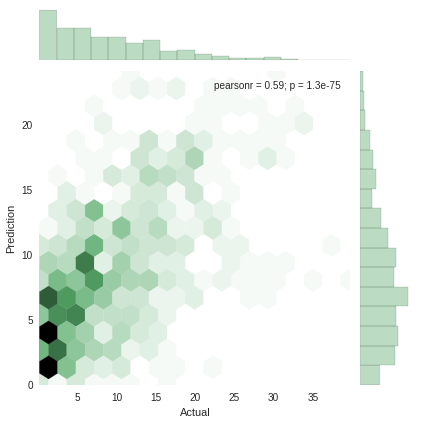

In [234]:

p_df = pd.DataFrame({'Prediction': lr_predictions,
                     'Actual': test_target.values})

pylab.figure(figsize=(10, 10))
sns.jointplot('Actual', 'Prediction', data=p_df, 
              kind="hex", color=sns.color_palette()[1])
#Let's take a look at our residuals using using just the categorical vars

In [235]:
from sklearn import metrics

test_metrics = {
    'Explained Variance': metrics.explained_variance_score,
    'MAE': metrics.mean_absolute_error,
    'MSE': metrics.mean_squared_error,
    'MedAE': metrics.median_absolute_error,
    'R2': metrics.r2_score
}
def metrics_report(*predictions):
    records = []
    for prediction_set in predictions:
        record = {'name': prediction_set.name}
        for metric_name in sorted(test_metrics.keys()):
            metric_func = test_metrics[metric_name]
            record[metric_name] = metric_func(test_target, prediction_set)
        records.append(record)
    frame = pd.DataFrame.from_records(records).set_index('name')
    return frame
        
metrics_report(lr_predictions)

,Explained Variance,MAE,MSE,MedAE,R2
name,,,,,
Linear Regression,0.335165,4.444201,36.212719,3.399445,0.331251


In [236]:
# We need to add reference models to track a baseline performance that we can compare our other models to
mean_response = np.mean(train_target)
mean_predictions = pd.Series(np.ones_like(test_target) * mean_response,
                             name='Mean Response')

median_response = np.median(train_target)
median_predictions = pd.Series(np.ones_like(test_target) * median_response,
                               name='Median Response')

metrics_report(mean_predictions, 
               median_predictions, 
               lr_predictions)

,Explained Variance,MAE,MSE,MedAE,R2
name,,,,,
Mean Response,0.000000,5.916924,54.151808,5.627266,-0.000034
Median Response,0.000000,5.746785,57.647159,4.800000,-0.064583
Linear Regression,0.335165,4.444201,36.212719,3.399445,0.331251


In [237]:
#Time for ElasticNet

from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import ElasticNet

estimator = ElasticNet()

parameters = {
    'alpha': np.linspace(0.1, 2, 10, endpoint=True),
    'l1_ratio': np.linspace(0, 1, 10, endpoint=True)
}

enet = GridSearchCV(estimator, parameters)
enet.fit(train_numdata, train_target)


GridSearchCV(cv=None, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'alpha': array([ 0.1    ,  0.31111,  0.52222,  0.73333,  0.94444,  1.15556,
        1.36667,  1.57778,  1.78889,  2.     ]), 'l1_ratio': array([ 0.     ,  0.11111,  0.22222,  0.33333,  0.44444,  0.55556,
        0.66667,  0.77778,  0.88889,  1.     ])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

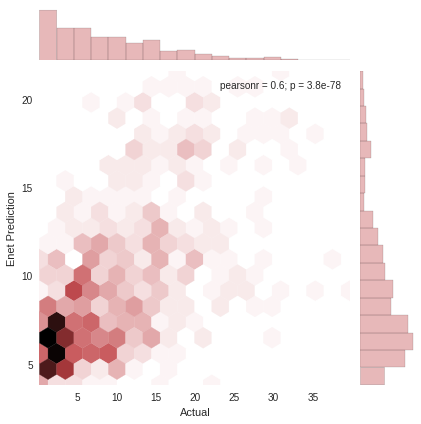

In [238]:
enet_predictions = pd.Series(enet.predict(test_numdata),
                             name='Elastic Net')
p_df = pd.DataFrame({'Enet Prediction': enet_predictions,
                     'Actual': test_target.values})

pylab.figure(figsize=(10, 10))
sns.jointplot('Actual', 'Enet Prediction', data=p_df, kind="hex",
              color=sns.color_palette()[2])

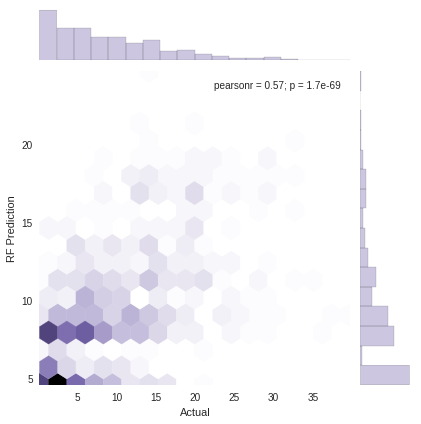

In [239]:
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
estimator = RandomForestRegressor()

parameters = {'n_estimators': (5, 10, 15, 20, 25, 30, 35),
              'max_depth': (3, 5, 7, 9, 11),
             }
rfr = GridSearchCV(estimator, parameters, n_jobs=3)
rfr.fit(train_this, train_target)

rfr_predictions = pd.Series(rfr.predict(test_this),
                            name='Random Forest')

p_df = pd.DataFrame({'RF Prediction': rfr_predictions,
                     'Actual': test_target.values})

pylab.figure(figsize=(10, 10))
sns.jointplot('Actual', 'RF Prediction', data=p_df, kind="hex",
              color=sns.color_palette()[3])


In [240]:
metrics_report(mean_predictions,
               median_predictions,
               lr_predictions,
               enet_predictions,
               rfr_predictions)

,Explained Variance,MAE,MSE,MedAE,R2
name,,,,,
Mean Response,0.000000,5.916924,54.151808,5.627266,-0.000034
Median Response,0.000000,5.746785,57.647159,4.800000,-0.064583
Linear Regression,0.335165,4.444201,36.212719,3.399445,0.331251
Elastic Net,0.354220,4.635088,34.990091,4.025681,0.353830
Random Forest,0.323904,4.656359,36.613345,3.818018,0.323853


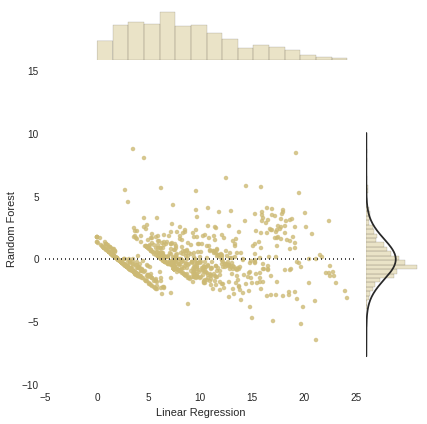

In [241]:

lr_diffs = lr_predictions - test_target
lr_diffs.name = 'LinearRegression Error'
rfr_diffs = rfr_predictions - test_target
rfr_diffs.name = 'RandomForest Error'

sns.jointplot(lr_predictions, rfr_predictions, kind='resid', color=sns.color_palette()[4])

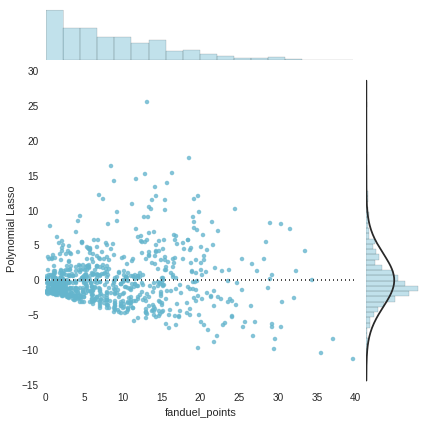

In [242]:

from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

degree = 2

model = make_pipeline(PolynomialFeatures(degree), Lasso())
model.fit(train_numdata, train_target)

poly_preds = pd.Series(model.predict(test_numdata),
                       name='Polynomial Lasso',
                       index=test_target.index)


sns.jointplot(test_target, 
              poly_preds,
              kind='resid',
              color=sns.color_palette()[5])   

In [243]:
metrics_report(mean_predictions,
               median_predictions,
               lr_predictions,
               enet_predictions,
               rfr_predictions,
               poly_preds)

,Explained Variance,MAE,MSE,MedAE,R2
name,,,,,
Mean Response,0.000000,5.916924,54.151808,5.627266,-0.000034
Median Response,0.000000,5.746785,57.647159,4.800000,-0.064583
Linear Regression,0.335165,4.444201,36.212719,3.399445,0.331251
Elastic Net,0.354220,4.635088,34.990091,4.025681,0.353830
Random Forest,0.323904,4.656359,36.613345,3.818018,0.323853
Polynomial Lasso,0.275439,4.810340,39.327519,4.009546,0.273730
